# GridWorld 2:

*GridWorld* is a world in the form of a board widely used as test environment in Reinforcement Learning. This board has several types of cells: initial, free, obstacles, terminal... and now teleportation points! The agents must go from the initial cell to the terminal one avoiding the obstacles and traveling the minimum distance.

Packages required for *GridWorld 2*:

In [1]:
import logging
import random
from typing import List
from scipy import stats as st

import numpy as np
import math

Functions to display information: 

In [2]:
def printMap(world):
  # Shows GridWorld map
  m = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if world.map[(i, j)] == 0: 
        m += " O "
      elif world.map[(i, j)] == -1:
        m += " X " 
      elif world.map[(i, j)] == 1:
        m += " F "
      elif world.map[(i, j)] == 2:
        m += " T "
    if i == world.size[0] - 1:
      m += "]\n"
    else:
      m += "\n"
  print(m)

def printPolicy(world, policy):
  # Shows policy
  p = "["
  for i in range(world.size[0]):
    for j in range(world.size[1]):
      if policy[i][j] == 0:
        p += " ^ "
      elif policy[i][j] == 1:
        p += " V "
      elif policy[i][j] == 2:
        p += " < "
      else:
        p += " > "
    if i == world.size[0] - 1:
      p += "]\n" 
    else:
      p += "\n"
  print(p)

# *World* class: 

This class stores the information of the world:

*   *Map*: Matrix that encodes the world with free cells (0), obstacles (-1) and terminal cells (1)
*   *Size*: Vector with the size of the world encoding matrix (width, height)

The following data is required to create a world:

*   Map size (width, height)
*   Terminal cell list
*   Obstacle cell list
*   Teletransportation

Notes:
* When the agent falls in an obstacle, it is trapped there forever.
* When the agent enters in a teletransportation point, it exits through the other.

For instance: 

w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])

Creates a world with 10 rows and 10 columns with a terminal state (9, 9), two obstacles in (2, 4) and (4, 2), and a teletransportation system between (0, 2) and (9, 7).

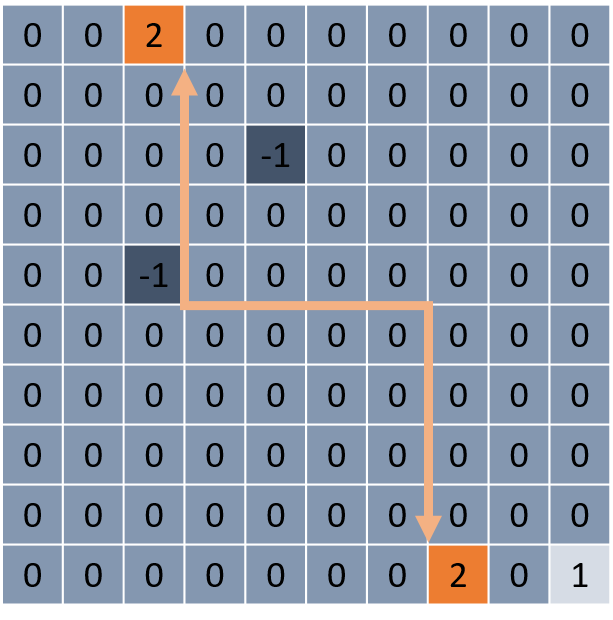

In [3]:
class World:

  def __init__(self, size, terminal, obstacle, hole):
    # Creates the world
    self.size = size
    self.map = {}
    for i in range(size[0]):
      for j in range(size[1]):
        # Free states
        self.map[(i, j)] = 0
        # Terminal states
        for t in terminal:
          if i==t[0] and j==t[1]:
            self.map[(i, j)] = 1
        # Obstacles
        for o in obstacle:
          if i==o[0] and j==o[1]:
            self.map[(i, j)] = -1
        # Teletransportation
        for h in hole:
          if i==h[0] and j==h[1]:
            self.map[(i, j)] = 2

Test for the *World* class:

In [4]:
if __name__ == "__main__":
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]



# *Agent* class:

This class controls the agent that learns by Reinforce Learning in *GridWorld*. 

The following data is required to create an agent:

*   *World*: World of the agent.
*   *Initial State*: Initial state of the agent.

The following methods are used to control the agent:

*   *nextState = move(state, action)*: Moves the agent from *state* to *nextState* applying *action*.
*   *reward = reward(nextState)*: Returns the *reward* received by the agent when going to *nextState*.
*   *nextState, reward = checkAction(state, action)*: Checks the *nextState* and *reward* when the agent takes the *action* in the *state*. This method do not change the internal state of the agent, so it can be used to sweep the state space.
*   *nextState, reward = executeAction(action)*: Executes the *action* in the current state and returns the *nextState* and *reward*. This method changes the internal state of the agent, so it should only be used when the agent travels along the world.

Note: You can change some properties of the agent (reward distribution, behavior with obstacles...) to improve the performance of the algorithms. 

In [5]:
class Agent:

  def __init__(self, world, initialState):
    # Create an agent
    self.world = world
    self.state = np.array(initialState)

  def move(self, state, action):
    # Manage state transitions
    nextState = state + np.array(action)
    if nextState[0] < 0:
      nextState[0] = 0
    elif nextState[0] >= self.world.size[0]:
      nextState[0] = self.world.size[0] - 1
    if nextState[1] < 0:
      nextState[1] = 0
    elif nextState[1] >= self.world.size[1]:
      nextState[1] = self.world.size[1] - 1
    if self.world.map[(nextState[0], nextState[1])] == 2:
      aux = nextState
      for i in range(self.world.size[0]):
        for j in range(self.world.size[1]):
          if self.world.map[(i, j)] == 2 and (nextState[0] != i and nextState[1] != j):
            aux = np.array([i, j])
            nextState = aux
    return nextState

  def reward(self, nextState):
    # Manage rewards
    if self.world.map[(nextState[0], nextState[1])] == -1:
      # Reward when the agent moves to an obstacle
      reward = -1 # ** Try different values **
    elif self.world.map[(nextState[0], nextState[1])] == 1:
      # Reward when the agent moves to a terminal cell
      reward = 1 # ** Try different values **
    else:
      # Reward when the agent moves to a free cell
      reward = 0 # ** Try different values ** 
    return reward

  def checkAction(self, state, action):
    # Plan the action
    nextState = self.move(state, action)
    if self.world.map[(state[0], state[1])] == -1: 
      nextState = state                            
    reward = self.reward(nextState)
    return nextState, reward

  def executeAction(self, action):
    # Plan and execute the action
    nextState = self.move(self.state, action)
    if self.world.map[(self.state[0], self.state[1])] == -1: 
      nextState = self.state     
    else: 
      self.state = nextState                                 
    reward = self.reward(nextState)
    return self.state, reward  

Test for the *Agent* class:

In [6]:
if __name__ == "__main__":
  # Create the world
  w = World((10, 10), [(9, 9)], [(2, 4), (4, 2)], [(0, 2), (9, 7)])
  printMap(w)
  # Create the agent
  a = Agent(w, (0, 0))
  # Move the agent through the main diagonal
  for i in range(1, 5):
    # Show the sates and rewards
    print(a.executeAction((0, 1)))

[ O  O  T  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  X  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  X  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  O  T  O  F ]

(array([0, 1]), 0)
(array([9, 7]), 0)
(array([9, 8]), 0)
(array([9, 9]), 1)


# Class work:

In this work you are going to implement the two most common value-based methods in reinforcement learning: SARSA and QLearning. In addition, you are going to test both algorithms in a set of scenarios to check if they work and compare their performance.

## Worlds: 

The following worlds are provided in multiple sizes to test the algorithms: 

*   World 1: Easy maze that can be solved in zigzag.
*   World 2: Random obstacles and useful teletransportation.
*   World 3: Random obstacles and bad teletransportation.
*   World 4: Hard maze with right and wrong ways.

Note: Feel free to use some of these scenarios or create your own scenarios. 

In [7]:
if __name__ == "__main__":
  
  # Word 1 small
  obstacles = []
  for j in range(0, 4):
    obstacles.append((j, 1))
  for j in range(1, 5):
    obstacles.append((j, 3))
  w1p = World((5, 5), [(4, 4)], obstacles, [])
  print("World 1: ")
  printMap(w1p)

  # World 1 medium
  obstacles = []
  for i in [1, 5]:
    for j in range(0, 8):
      obstacles.append((j, i))
  for i in [3, 7]:
    for j in range(1, 9):
      obstacles.append((j, i))
  w1m = World((9, 9), [(8, 8)], obstacles, [])
  print("World 1: ")
  printMap(w1m)

  # World 1 big
  obstacles = []
  for i in [1, 5, 9, 13, 17]:
    for j in range(0, 20):
      obstacles.append((j, i))
  for i in [3, 7, 11, 15, 19]:
    for j in range(1, 21):
      obstacles.append((j, i))
  w1g = World((21, 21), [(20, 20)], obstacles, [])
  print("World 1: ")
  printMap(w1g)

  # World 2 small
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w2p = World((5, 5), [(4, 4)], obstacles, [(2, 0), (4, 2)])
  print("World 2: ")
  printMap(w2p)

  # World 2 medium
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w2m = World((10, 10), [(9, 9)], obstacles, [(3, 1), (8, 6)])
  print("World 2: ")
  printMap(w2m)

  # World 2 big
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w2g = World((21, 21), [(20, 20)], obstacles, [(6, 2), (18, 14)])
  print("World 2: ")
  printMap(w2g)

  # World 3 small
  obstacles = []
  for i in range(3):
    obstacles.append((np.random.randint(1, 4), np.random.randint(1, 4)))  
  w3p = World((5, 5), [(4, 4)], obstacles, [(4, 0), (0, 4)])
  print("World 3: ")
  printMap(w3p)

  # World 3 medium
  obstacles = []
  for i in range(10):
    obstacles.append((np.random.randint(1, 9), np.random.randint(1, 9)))  
  w3m = World((10, 10), [(9, 9)], obstacles, [(8, 1), (1, 8)])
  print("World 3: ")
  printMap(w3m)

  # World 3 big
  obstacles = []
  for i in range(50):
    obstacles.append((np.random.randint(1, 19), np.random.randint(1, 19)))  
  w3g = World((21, 21), [(20, 20)], obstacles, [(18, 2), (2, 18)])
  print("World 3: ")
  printMap(w3g)

  # World 4
  obstacles = [(0,1),(0,3),(0,9),(0,15),(0,16),(0,17),(0,19),
               (1,1),(1,3),(1,4),(1,5),(1,6),(1,7),(1,9),(1,10),(1,11),(1,12),(1,13),(1,17),(1,19),
               (2,1),(2,9),(2,13),(2,15),(2,16),(2,17),(2,19),
               (3,1),(3,3),(3,5),(3,7),(3,9),(3,11),(3,16),(3,19),
               (4,3),(4,5),(4,7),(4,8),(4,9),(4,10),(4,11),(4,12),(4,13),(4,14),(4,16),(4,18),(4,19),
               (5,0),(5,1),(5,2),(5,3),(5,5),(5,9),(5,16),
               (6,5),(6,6),(6,7),(6,9),(6,10),(6,11),(6,12),(6,13),(6,14),(6,16),(6,17),(6,19),
               (7,0),(7,1),(7,2),(7,3),(7,5),(7,7),(7,9),(7,19),
               (8,3),(8,7),(8,8),(8,9),(8,12),(8,13),(8,14),(8,15),(8,16),(8,17),(8,18),(8,19),
               (9,1),(9,3),(9,5),(9,7),(9,11),(9,12),(9,19),(9,20),
               (10,1),(10,3),(10,5),(10,6),(10,7),(10,9),(10,11),(10,14),(10,15),(10,16),(10,17),
               (11,1),(11,3),(11,5),(11,9),(11,11),(11,13),(11,14),(11,17),(11,18),(11,19),
               (12,1),(12,5),(12,6),(12,8),(12,9),(12,11),(12,13),(12,19),
               (13,1),(13,2),(13,3),(13,4),(13,5),(13,8),(13,15),(13,16),(13,17),(13,19),
               (14,4),(14,7),(14,8),(14,10),(14,12),(14,13),(14,15),(14,19),
               (15,0),(15,1),(15,2),(15,6),(15,7),(15,10),(15,13),(15,14),(15,15),(15,17),(15,18),(15,19),(15,20),
               (16,2),(16,3),(16,5),(16,6),(16,7),(16,8),(16,9),(16,10),(16,11),(16,15),(16,17),
               (17,0),(17,3),(17,5),(17,9),(17,13),(17,14),(17,15),(17,17),(17,19),
               (18,0),(18,1),(18,5),(18,6),(18,7),(18,9),(18,10),(18,11),(18,15),(18,19),
               (19,1),(19,2),(19,4),(19,5),(19,11),(19,13),(19,14),(19,15),(19,16),(19,17),(19,18),(19,19),
               (20,7),(20,8),(20,9),(20,11),(20,19)]          
  print("World 4: ")
  w4 = World((21, 21), [(20, 20)], obstacles, [])
  printMap(w4)

World 1: 
[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O 
 O  O  O  X  O  O  O  X  F ]

World 1: 
[ O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O  X  O  O  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O 
 O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  O  X  

## SARSA:

*SARSA* (State-Action-Reward-State-Action) is a value-based method that solves reinforcement learning problems. *SARSA* computes iteratively the value function $Q(S,A)$ and then determines the optimal policy $\pi$.

*SARSA* received this name because of the five variables involved in its update function: current state ($S_t$), current action ($A_t$), current reward ($R_t$), next state ($S_{t+1}$) and next action ($A_{t+1}$). This equation is shown below:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]
\end{equation}

Note: $\alpha$ is the episode length and $\gamma$ the discount factor.

The *SARSA* algorithm follows this scheme: 

1.   Initialize $Q(S,A)$ for every state and action 
2.   **Loop** (repeat $3-9$ until convergence):
3.   Initialize $S_t$
4.   Choose $A_t$ for $S_t$ following the policy $Q(S,A)$
5.   **Loop** (repeat $6-9$ until $S_t$ is terminal):
6.   Take $A_t$ in $S_t$ and observe $R_t$ and $S_{t+1}$
7.   Choose $A_{t+1}$ for $S_{t+1}$ following the policy $Q(S,A)$
8.   Update the value $Q(S_t, A_t)$ with the update equation
9.   Take $S_{t+1}$ and $A_{t+1}$ as the new $S_t$ and $A_t$

The *SARSA* algorithm uses a parameter $\epsilon \in (0, 1)$ to search a balance between exploration and exploitation. When it chooses $A_t$ for $S_t$, if a random number is less than $\epsilon$, it will take a random action; whereas if that number is more than $\epsilon$, it will take the best action.

## Exercise 1:

Implement the SARSA algorithm for the previously defined agent and world.

Algorithm is defined below, check the class _ReinforcedLearning_ with the common attributes and functions of SARSA and QLearning and the inner implementations of both algorithms, both defined as _Sarsa_ and _QLearning_ classes that extends the _ReinforcedLearning_ class.

Below the definition of both algorithms some tests can be found

## Q-Learning:

*Q-Learning* is the most common value-based method to solve reinforcement learning problems. This algorithm receives this name from $Q(S,A)$, the value function that updates during its execution. *Q-Learning* is very similar to *SARSA*, but it uses a different update equation:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma max_a{Q(S_{t+1}}, a) - Q(S_t,A_t)]
\end{equation}

In this case, the action $A_{t+1}$ in $S_{t+1}$ is taken to exploit the maximum value.

The *Q-Learning* algorithm follows this scheme: 

1.   Initialize $Q(S,A)$ for every state and action 
2.   **Loop** (repeat $3-8$ until convergence):
3.   Initialize $S_t$
4.   **Loop** (repeat $6-8$ until $S_t$ is terminal):
5.   Choose $A_t$ for $S_t$ following the policy $Q(S,A)$
6.   Take $A_t$ in $S_t$ and observe $R_t$ and $S_{t+1}$
7.   Update the value $Q(S_t, A_t)$ with the update equation
8.   Take $S_{t+1}$ as the new $S_t$

## Exercise 2:
Implement the Q-Learning algorithm for the previously defined agent and world.

In [8]:
# Solution: Q-Learning code

## Analysis:

*SARSA* and *Q-Learning* are very similar, they can be applied to the same problems and usually obtain the same solutions. However, the results of both algorithms can be different in certains problems: e.g., in the Cliffworld, SARSA performs safer movements but obtains less value than Q-Learning ([interesting article](https://medium.com/gradientcrescent/fundamentals-of-reinforcement-learning-navigating-cliffworld-with-sarsa-and-q-learning-cc3c36eb5830)).

## Exercise 3:

Analyze the results of both algorithms:

1.   Performance of SARSA and Q-Learning: Which problems do they solve? When do they find the optimal solution? What are the causes of these results?

2.   Differences between SARSA and Q-Learning: Which algorithm solves more scenarios? Which one converges faster? Which one obtains more value?

Note: The following variables can be interesting to analyze the results: Diference between resultant and optimal policies, number of iterations required to converge, total return of the problem, and return per episode.

3.   Differences with more exploration (higher $\epsilon$) and more exploitation (lower $\epsilon$). Which converges faster? Which maximizes return?

4.   Differences with other parameters: number of episodes, learning rate ($\alpha$), and discount factor ($\gamma$). Which combination gives the best results?

In [9]:
# Solution: Code required to generate results

**Solution**: Comments on the results.

Note: Feel free to add all the text and code blocks that you need to answer the questions.

## Classes

In [148]:
# Solution COMMON class

class ReinforcedLearning():
  def __init__(self, *args, **kwargs):
    self._parameters = kwargs.copy()
    self.__config = dict({
      'ready': False
    })

  @property
  def world(self) -> World:
    return self._parameters['world']

  @property
  def agent(self) -> Agent:
    return self._parameters['agent']

  @property
  def actions(self) -> List:
    return self._parameters['actions']

  @property
  def alpha(self) -> float:
    return self._parameters['alpha']

  @property
  def gamma(self) -> float:
    return self._parameters['gamma']

  @property
  def epsilon(self):
    return self._parameters['epsilon']

  @property
  def q(self) -> np.ndarray:
    return self._parameters['q']

  @property
  def config(self):
    return self.__config.copy()

  def set_alpha(self, alpha):
    self._parameters['alpha'] = alpha

  def set_gamma(self, gamma):
    self._parameters['gamma'] = gamma

  def set_epsilon(self, epsilon):
    self._parameters['epsilon'] = epsilon

  def configure(self, **kwargs):
    self.__config = kwargs.copy()
    if 'max_iterations' not in self.__config:
      self.__config['max_iterations'] = np.int32(10**3)  # Run for at most this time
    if 'max_steps' not in self.__config:
      self.__config['max_steps'] = np.int32(10**2)  # Each iteration will run for this steps
    if 'theta' not in self.__config:
      self.__config['theta'] = np.float32(0.01)  # Difference threshold
    if 'init_value' not in self.__config:
      self.__config['init_value'] = 0
    if 'q' not in self.__config:
      self._parameters['q'] = np.ones(
        (self.world.size[0], self.world.size[1], len(self.actions))
      ) * (self.__config['init_value']) # Q(S,A) = init_value (0, -1, 1, etc)
    if 'qs' not in self.__config:
      self._parameters['qs'] = [self.q.copy()]  # Q matrix history
    self.__config['ready'] = True

    __rows, __cols = self.world.size
    for __j in range(__rows):
      for __i in range(__cols):
        if self.world.map[(__j, __i)] == 1:  # Q(Terminal, A) = 0
          self._parameters['q'][__j][__i] = np.zeros(shape=(len(self.actions,)))

  def _lookup_action(self, action_idx):
    return self.actions[action_idx]

  def _choose_action(self, state):
    """
    Chooses an action (index) either randomly or maximizing the reward in a given state
    :param state: current state where the action will be taken
    :return: index of action to be taken
    """
    __rnd = st.uniform.rvs()
    if __rnd < self.epsilon:
      __action = np.random.choice(np.arange(0, len(self.actions)), size=1)[0]
    else:
      __action = np.argmax(self._lookup_q(state))
    return __action

  def _difference(self, qs: List[np.ndarray], epoch):
    dif = np.abs(np.subtract(qs[epoch-1], qs[epoch-2]))
    return np.max(dif) / (np.max(self.q) + 1e-5)  # avoid zero division

  def _lookup_q(self, state, action:int=None):
    if action is not None:
      return self.q[state[0]][state[1]][action]
    else:
      return self.q[state[0]][state[1]]

  def _set_q(self, state, action, value):
    self._parameters['q'][state[0]][state[1]][action] = value

  def _update_q(self, state, next_state, action, next_action):
    """
    Performs
    \begin{equation}
      Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha [R_t + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t)]$
    \end{equation}
    :param state: current state
    :param next_state: next state
    :param action: current action idx
    :param next_action: next action idx
    """
    __curr = self._lookup_q(state, action)  # Q(S_t,A_t)
    _, __reward = self.agent.checkAction(state, self._lookup_action(action))
    __next = __reward + self.gamma * self._lookup_q(next_state, next_action)  # R_t + \gamma Q(S_{t+1}, A_{t+1})
    __new_value = __curr + self.alpha * (__next - __curr)  # Whole equation
    self._set_q(state, action, __new_value)

  def run(self):
    return NotImplementedError('Method not implemented in abstract class')

  def solve(self):
    """
    Returns the best path starting from agent's current state
    :return: Tuple(List, Bool) --> (path_array, path_found?)
    """
    __epsilon = self.epsilon
    self._parameters['epsilon'] = 0  # always choose the best action
    __starter_state = self.agent.state
    
    __convert = lambda s: (s[0], s[1])  # converts state to tuple so it can be hashed
    __path = [__starter_state.tolist()]
    __path_set = set()
    __path_set.add(__convert(__starter_state))
    
    __found = True
    while True:
      __action = self._choose_action(self.agent.state)
      __prev_state = self.agent.state
      __next_state, __reward = self.agent.executeAction(self._lookup_action(__action))
      __path.append(__next_state.tolist())
      if __convert(__next_state) in __path_set:  # state was already visited
          logging.warning(f'Agent traveling through visited state {__prev_state}. Exiting with no path.')
          __found = False
          break
      __path_set.add(__convert(__next_state))  # add next state to the path
      if __reward == 1:
        break
    self._parameters['epsilon'] = __epsilon  # Restore epsilon value
    self.agent.state = __starter_state
    return __path, __found

  def print_q(self):
    __q = self.q.copy()
    __rows, __cols = self.world.size
    print('[')
    for __j in range(__rows):
      print(f'  Row {__j} [')
      for __i in range(__cols):
        print(f'    Col {__i}' + str(__q[__j][__i]))
      print('  ]')
    print(']')

In [152]:
# Solution: SARSA code

class Sarsa(ReinforcedLearning):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def run(self):
    """
    Runs SARSA algorithm
    """
    
    if self.config['ready'] is False:
      logging.critical('Sarsa is not configured. Run sarsa.configure')
      return
    __max_iterations = self.config['max_iterations']
    __max_steps = self.config['max_steps']
    __theta = self.config['theta']
    __qs = self._parameters['qs']  # Q history --> current: starter Q

    __starter_state = self.agent.state
    for __epoch in range(__max_iterations):
      self.agent.state = __starter_state  # Set S_t
      __action = self._choose_action(self.agent.state)  # Choose A_t
      # print(f'Starter action: {__action}')
      __c = 0
      __stop = False
      while __stop is False:
        # print(f'Action: {self._lookup_action(__action)} @ idx.{__action}')
        __next_state, __reward = self.agent.checkAction(self.agent.state, self._lookup_action(__action))  # Check next state and reward with chosen action --> S_{t+1}, R_t
        # print(f'Next state: {__next_state}')
        __next_action = self._choose_action(self.agent.state)  # Choose A_{t+1}
        self._update_q(state=self.agent.state, next_state=__next_state, action=__action, next_action=__next_action)  # Update Q(S_t, A_t) with the update equation

        if __reward == 1:  # Terminal state reached --> exit
          break

        self.agent.executeAction(self._lookup_action(__action))  # Take S_{t} = S_{t+1} <-- Update current state with the next state
        __action = __next_action  # Take A_{t} = A_{t+1} <-- Update current action with the next action

        __c += 1
        if __max_steps is not None:
          __stop = __c >= __max_steps  # Max steps reached
        else:
          __stop = self.world.map[(self.agent.state[0], self.agent.state[1])] == 1  # Terminal state
      __qs.append(self.q.copy())
      if self._difference(qs=__qs, epoch=__epoch) < __theta:  # Convergence reached
        break
    self.agent.state = __starter_state  # Restore agent's position
    # print('SARSA finished')
    return __qs

In [153]:
# Solution QLearning code

class QLearning(ReinforcedLearning):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)

  def _choose_next_action(self, state):
    """
    Chooses an action (index) maximizing the reward in a given state
    :param state: current state where the action will be taken
    :return: index of action to be taken
    """
    return np.argmax(self._lookup_q(state))

  def run(self):
    """
    Runs QLearning algorithm
    """
    
    if self.config['ready'] is False:
      logging.critical('QLearning is not configured. Run qlearning.configure')
      return
    __max_iterations = self.config['max_iterations']
    __max_steps = self.config['max_steps']
    __theta = self.config['theta']
    __qs = self._parameters['qs']  # Q history --> current: starter Q
    
    __starter_state = self.agent.state
    for __epoch in range(__max_iterations):
      self.agent.state = __starter_state  # Set S_t
      # print(f'Starter action: {__action}')
      for _ in range(__max_steps):
        __action = self._choose_action(self.agent.state)  # Choose A_t following Q(S,A) policy
        # print(f'Action: {self._lookup_action(__action)} @ idx.{__action}')
        __next_state, __reward = self.agent.checkAction(self.agent.state, self._lookup_action(__action))  # Check next state and reward with chosen action --> S_{t+1}, R_t
        # print(f'Next state: {__next_state}')
        __next_action = self._choose_next_action(self.agent.state)  # Choose A_{t+1} <-- argmax(Q(S_{t+1}, a))
        self._update_q(state=self.agent.state, next_state=__next_state, action=__action, next_action=__next_action)  # Update Q(S_t, A_t) with the update equation
        if __reward == 1:  # Terminal state reached --> exit
          break
        self.agent.executeAction(self._lookup_action(__action))  # Take S_{t} = S_{t+1} <-- Update current state with the next state
      __qs.append(self.q.copy())
      if self._difference(qs=__qs, epoch=__epoch) < __theta:  # Convergence reached
        break
    self.agent.state = __starter_state  # Restore agent's position
    # print('QLearning finished')
    return __qs

## Tests

In [ ]:
w = w1p
start = (0,0)
agent = Agent(w, start)
actions = np.array([(0,1), (1,0),(-1,0), (-1,0)])

sarsa = Sarsa(
  world=w,
  agent=agent,
  actions=actions,
  alpha=0.01,
  gamma=.95,
  epsilon=.9
)

sarsa.configure(max_iterations=10**3, max_steps=300, theta=1e-6)
sarsa.run()

sarsa.set_epsilon(.8)
sarsa.run()

pass

In [143]:
# We can try to run the algorithm multiple times varying epsilon factor
# max_attemps = 10
# for i in range(0, max_attemps):
#   __epsilon = np.float32(1 - (i / max_attemps + 1e-3))
#   print(f'Run: [{i+1}/{max_attemps}] @ Epsilon: {__epsilon}')
#   sarsa.set_epsilon(__epsilon)
#   sarsa.run()
#   path, path_found = sarsa.solve()
#   # print(f'Path: {path} @ Found: {path_found}')
#   if path_found:
#     break
# #
# if path_found is False:
#   print(f'Extra @ Epsilon: {.5}')
#   sarsa.set_epsilon(.5)
#   sarsa.run()

# if path[1] is False:
#   sarsa.set_epsilon(.1)
#   path = sarsa.solve()

In [145]:
printMap(sarsa.world)
sarsa.print_q()
path = sarsa.solve()
print(path)
pass

[ O  O  O  O  O  O  O  O  O  O 
 O  X  O  O  O  O  O  O  O  O 
 O  O  O  X  O  O  O  O  X  O 
 O  T  O  X  O  O  O  O  O  O 
 O  O  O  O  O  X  O  O  O  O 
 O  O  O  O  O  O  O  O  X  O 
 O  O  O  X  O  O  O  X  O  O 
 O  O  O  O  O  O  O  O  O  O 
 O  O  O  O  O  O  T  X  O  O 
 O  O  O  O  O  O  O  O  O  F ]

[
  Row 0 [
    Col 0[ -7.94093129 -12.17377358  -8.53820867  -8.5810359 ]
    Col 1[ -3.23782749 -20.          -8.48500518  -7.91160911]
    Col 2[-2.53492044 -4.82484069 -3.33305551 -3.20656523]
    Col 3[-1.51577887 -5.05846041 -2.65928122 -2.69989488]
    Col 4[-1.78225507 -1.52192816 -1.45260195 -1.45235672]
    Col 5[-2.01610568 -1.99418063 -1.76112676 -1.7673944 ]
    Col 6[-1.93628334 -2.57985481 -2.03399138 -2.00476352]
    Col 7[-1.09222894 -3.58648451 -1.9535159  -1.79847657]
    Col 8[ 0.06322952 -3.67630519 -1.31740353 -1.45635659]
    Col 9[0.06485154 0.07399043 0.06526409 0.06439091]
  ]
  Row 1 [
    Col 0[-20.          -7.67051574  -9.19229102  -9.50334855]
    

In [140]:
w = w1p
start = (0,0)
agent = Agent(w, start)
actions = np.array([(0,1), (1,0),(-1,0), (-1,0)])

qlearning = QLearning(
  world=w,
  agent=agent,
  actions=actions,
  alpha=0.05,
  gamma=.95,
  epsilon=.9
)

qlearning.configure(max_iterations=10**4, max_steps=300, theta=1e-12)
qlearning.run()

pass

In [141]:
printMap(qlearning.world)
qlearning.print_q()
path = qlearning.solve()
print(path)
pass

[ O  X  O  O  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  X  O  X  O 
 O  O  O  X  F ]

[
  Row 0 [
    Col 0[-20.   0.   0.   0.]
    Col 1[-20. -20. -20. -20.]
    Col 2[ 0.        -0.0019884  0.         0.       ]
    Col 3[0. 0. 0. 0.]
    Col 4[0. 0. 0. 0.]
  ]
  Row 1 [
    Col 0[-1.99997526e+01  0.00000000e+00 -7.20606321e-09 -4.04124858e-09]
    Col 1[-20. -20. -20. -20.]
    Col 2[-1.10205052e-01  0.00000000e+00 -4.02652291e-05 -6.15294237e-06]
    Col 3[-3.22340777 -3.18924958 -3.18813019 -3.19029193]
    Col 4[0. 0. 0. 0.]
  ]
  Row 2 [
    Col 0[-1.96270580e+01  0.00000000e+00 -8.87338026e-07 -3.80721579e-05]
    Col 1[-19.99999556 -19.99999555 -19.99999556 -19.99999557]
    Col 2[-0.29772418  0.          0.          0.        ]
    Col 3[-5.42052429 -5.38907194 -5.39645417 -5.40544268]
    Col 4[0. 0. 0. 0.]
  ]
  Row 3 [
    Col 0[-16.8301759   0.          0.          0.       ]
    Col 1[-19.99826702 -19.99826539 -19.99826784 -19.9982656 ]
    Col 2[-3.00357481e-01  0.0000000